# Ex 2 - Transfer learning
##### Group: 02
###### Student 1: Naël Telfser
###### Student 2: Simon Braillard
###### Student 3: Simon Barras

In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds  # first: pip install tensorflow_datasets

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

## Load the Dataset and visualize it

In [2]:
# Download and split the food101 dataset
(train_ds, validation_ds, test_ds), info = tfds.load(
    "food101",
    split=["train", "validation[:50%]", "validation[50%:]"],
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteONBEWN/food101-train.tfrecord*...:   0%|          …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteONBEWN/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [3]:
# Filter the dataset to keep the first 20 classes only.
N_CLASSES = 20
CLASS_NAMES = info.features['label'].names[:N_CLASSES]

train_ds = train_ds.filter(lambda img, label: label < N_CLASSES)
validation_ds = validation_ds.filter(lambda img, label: label < N_CLASSES)
test_ds = test_ds.filter(lambda img, label: label < N_CLASSES)

In [4]:
# This step takes too much time. It is not madatory to execute it.
print("Training samples: %d" % train_ds.reduce(0, lambda x, _: x + 1).numpy())
print("Validation samples: %d" % validation_ds.reduce(0, lambda x, _: x + 1).numpy())
print("Tests samples: %d" % validation_ds.reduce(0, lambda x, _: x + 1).numpy())

Training samples: 15000
Validation samples: 2514
Tests samples: 2514


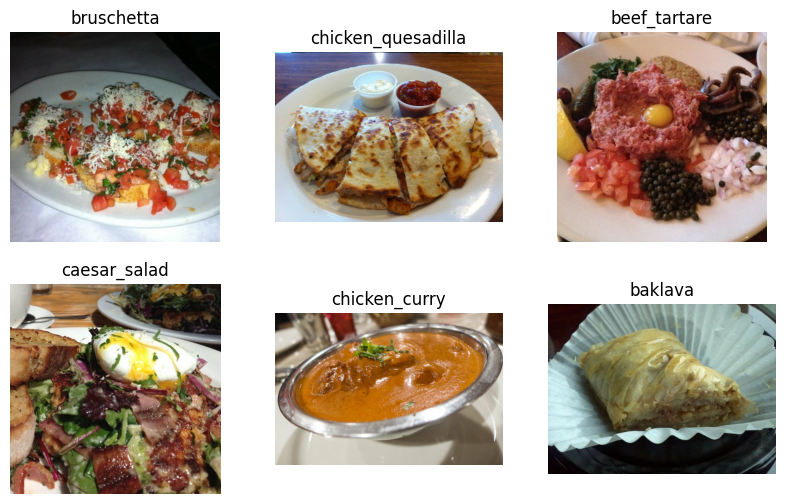

In [5]:
plt.figure(figsize=(10, 6))
for i, (image, label) in enumerate(train_ds.take(6)):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label])
    plt.axis("off")

## Resize and normalize

In [6]:
train_ds = train_ds.map(lambda img, label: (tf.image.resize(img, (224, 224)), label))
validation_ds = validation_ds.map(lambda img, label: (tf.image.resize(img, (224, 224)), label))
test_ds = test_ds.map(lambda img, label: (tf.image.resize(img, (224, 224)), label))

In [7]:
# Normalize the images
train_ds = train_ds.map(lambda img, label: (img / 255, label))
validation_ds = validation_ds.map(lambda img, label: (img / 255, label))
test_ds = test_ds.map(lambda img, label: (img / 255, label))

In [8]:
# One hot encode the labels
train_ds = train_ds.map(lambda img, label: (img, tf.one_hot(label, N_CLASSES)))
validation_ds = validation_ds.map(lambda img, label: (img, tf.one_hot(label, N_CLASSES)))
test_ds = test_ds.map(lambda img, label: (img, tf.one_hot(label, N_CLASSES)))

## Data-Augmentation

In [9]:
# Data augmentation

# Create the batches
B = 128
train_ds = train_ds.batch(B)
validation_ds = validation_ds.batch(B)
test_ds = test_ds.batch(B)

# Add data augmentation


## Training
### Step 1: Only train the head of the network

In [10]:
%%time
# Load the pretrained model from the available models: https://keras.io/api/applications/#available-models. 
# Load the imagenet weights but do not include the ImageNet classifier at the top.
#
# Tip, don't choose models that are too big because the training could take hours. 
# A model like mobilenet is more than enough for the exercise.

# MobileNetV2
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet')

# Freeze the base_model
base_model.trainable = False

# Create the model structure
model = tf.keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(100),
    keras.layers.Dropout(0.5),
    keras.layers.Activation('relu'),
    keras.layers.Dense(N_CLASSES, activation='softmax')
])
model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 100)               128100    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                           

In [ ]:
%%time

# Compile the model with your optimizer, your loss and your metrics
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Optional: Define and use callbacks

step1_history = model.fit(train_ds, epochs=10, validation_data=validation_ds, verbose=1)

Epoch 1/10
118/118 [==============================] - 140s 1s/step - loss: 2.2200 - accuracy: 0.3276 - val_loss: 1.3170 - val_accuracy: 0.6289
Epoch 2/10
118/118 [==============================] - 126s 1s/step - loss: 1.5772 - accuracy: 0.5170 - val_loss: 1.1457 - val_accuracy: 0.6615
Epoch 3/10
118/118 [==============================] - 123s 1s/step - loss: 1.4023 - accuracy: 0.5677 - val_loss: 1.0770 - val_accuracy: 0.6675
Epoch 4/10
118/118 [==============================] - 122s 1s/step - loss: 1.2991 - accuracy: 0.5981 - val_loss: 1.0364 - val_accuracy: 0.6806
Epoch 5/10
118/118 [==============================] - 121s 1s/step - loss: 1.2290 - accuracy: 0.6211 - val_loss: 1.0118 - val_accuracy: 0.6885
Epoch 6/10
118/118 [==============================] - 119s 1s/step - loss: 1.1625 - accuracy: 0.6370 - val_loss: 0.9880 - val_accuracy: 0.6941
Epoch 7/10
118/118 [==============================] - 123s 1s/step - loss: 1.1300 - accuracy: 0.6485 - val_loss: 0.9740 - val_accuracy: 0.6913

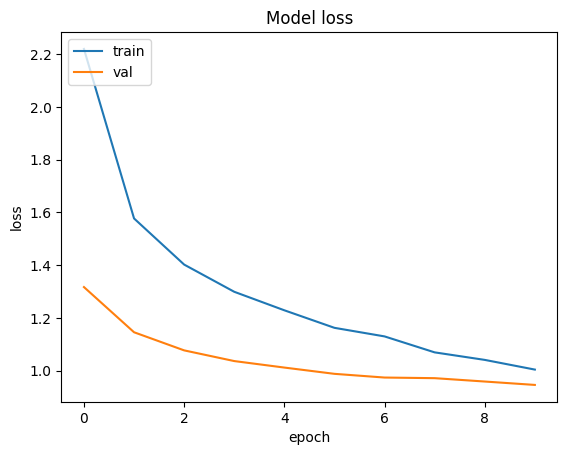

In [12]:
def plot_history(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.title('Model ' + metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


plot_history(step1_history, 'loss')

### Step 2: Fine-Tune the whole model

In [14]:
%%time


# Unfreeze the pretrained base.
base_model.trainable = True
for layer in base_model.layers:
    layer.trainable = True


# Compile the model again
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.00001),
              metrics=['accuracy'])

# Retrain the model
step2_history = model.fit(train_ds, epochs=10, validation_data=validation_ds, verbose=1)

Epoch 1/10
118/118 [==============================] - 184s 1s/step - loss: 1.2135 - accuracy: 0.6228 - val_loss: 0.9897 - val_accuracy: 0.7001
Epoch 2/10
118/118 [==============================] - 145s 1s/step - loss: 1.0906 - accuracy: 0.6623 - val_loss: 0.9705 - val_accuracy: 0.7009
Epoch 3/10
118/118 [==============================] - 141s 1s/step - loss: 0.9883 - accuracy: 0.6907 - val_loss: 0.9467 - val_accuracy: 0.7049
Epoch 4/10
118/118 [==============================] - 143s 1s/step - loss: 0.9147 - accuracy: 0.7167 - val_loss: 0.9250 - val_accuracy: 0.7092
Epoch 5/10
118/118 [==============================] - 145s 1s/step - loss: 0.8429 - accuracy: 0.7399 - val_loss: 0.9036 - val_accuracy: 0.7152
Epoch 6/10
118/118 [==============================] - 144s 1s/step - loss: 0.7860 - accuracy: 0.7562 - val_loss: 0.8853 - val_accuracy: 0.7212
Epoch 7/10
118/118 [==============================] - 143s 1s/step - loss: 0.7343 - accuracy: 0.7708 - val_loss: 0.8683 - val_accuracy: 0.7263

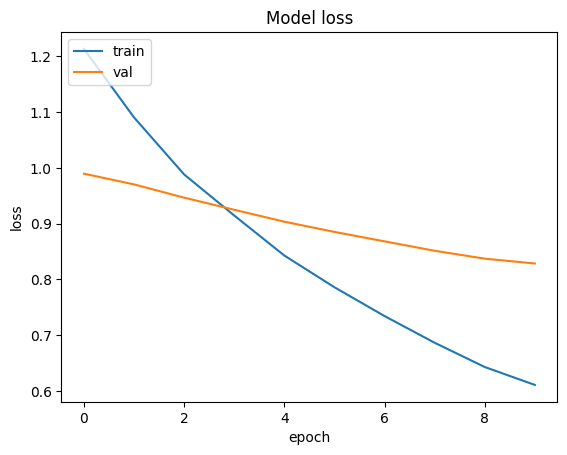

In [15]:
plot_history(step2_history, 'loss')

## Test the fine-tuned model

In [16]:
%%time
# Predict the test set
y_pred = model.predict(test_ds, verbose=1)

# De-encode the onehot encoded labels
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds], axis=0)

20/20 [==============================] - 26s 1s/step
CPU times: user 58.3 s, sys: 2.32 s, total: 1min
Wall time: 1min 2s


In [17]:
%%time

# Accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

Accuracy: 0.7252614641995173
CPU times: user 1.71 ms, sys: 911 µs, total: 2.63 ms
Wall time: 2.87 ms


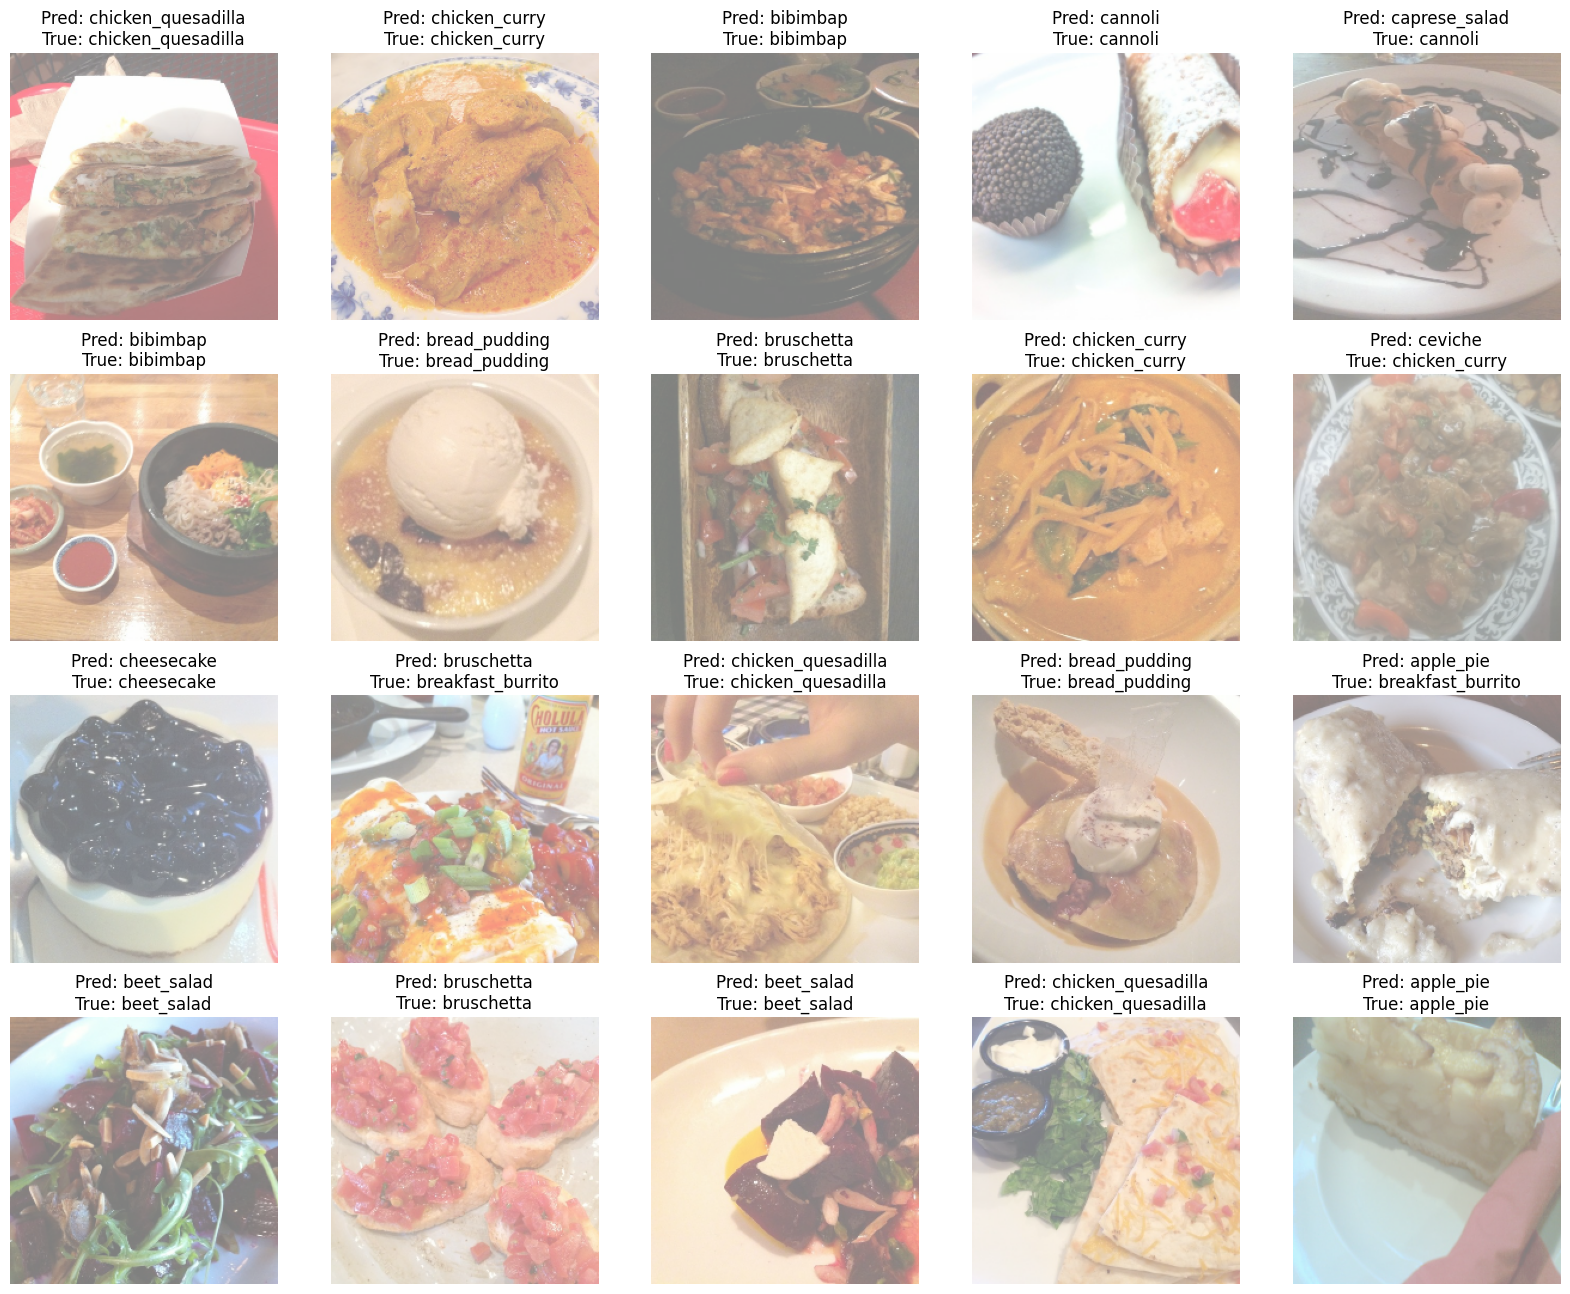

In [18]:
def show_images_prediction(page=0):
    test_examples = (np.concatenate([x.numpy() for x, y in test_ds]) + 1) / 2 * 255
    test_examples = test_examples.astype("uint32")

    page_size = 20
    nrows = 4
    ncols = 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
    fig.set_size_inches(20, 16)

    start_i = page * page_size
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(test_examples[i + start_i])
        ax.set_axis_off()
        ax.set_title("Pred: " + CLASS_NAMES[y_pred[i + start_i]] + "\nTrue: " + CLASS_NAMES[y_true[i + start_i]])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

    plt.show()


show_images_prediction(2)

The fine-tuned version as a better accuracy but it takes a lot of time and ressources to train it. Depending on the use case (if a lower accuracy is acceptable), we will prefere to train only the head of the network.